Your Name: Dylan Rodrigues

Your ID Number: 24121479

# Etivity 3 - Task 2: Use Tensorflow and Keras to build a model for sign-language digit classification using transfer learning based on the MobileNet CNN model and then do fine-tuning.

In the previous task you developed and used CNN models using TensorFlow Keras libraries. In this notebook you will carry out transfer learning by modifying the MobileNet model [1] trained on the ImageNet [2] database and then perform fine-tuning to try and imporve the performance.


By the end of this notebook, you'll be able to:

* Load a pre-trained MobileNet model using the TensorFlow/Keras framework.
* Replace the last layer from 1000 nodes down to 10 nodes for sign-language digit classification.
* Modify the trainable paramaters to false except for the last layer.
* Fit the model to the training set.
* Analyse the model perfromance.
* Perform fine-tuning by making more layer parameters trainable and retrain the model.
* Analyse the fine-tuned model performance.
* Store your model architecture.


### Important Note on Submission

There are code exercises to complete in this task. Use the notes provided to help you build understanding. Insert your code entries into the cell areas marked with the 'enter code here' text as below, so that grading can easily be assessed.

\### **ENTER CODE HERE**

Please make sure you are not doing the following:

1. You have not added any _extra_ `print` statement(s) in the assignment.
2. You have not added any _extra_ code cell(s) in the assignment.
3. You have not changed any of the function parameters.
4. You are not using any global variables inside your graded exercises. Unless specifically instructed to do so, please refrain from it and use the local variables instead.
5. You are not changing the assignment code where it is not required, like creating _extra_ variables.


Let's get started!

In [4]:
!unzip -o images.zip -d /content/images

Archive:  images.zip
   creating: /content/images/images/
  inflating: /content/images/images/Sign-Digits_dataset_preview.PNG  


In [2]:
!unzip -o Sign-Language-Digits-Dataset.zip -d /content/Sign-Language-Digits-Dataset

Archive:  Sign-Language-Digits-Dataset.zip
   creating: /content/Sign-Language-Digits-Dataset/Sign-Language-Digits-Dataset/
   creating: /content/Sign-Language-Digits-Dataset/Sign-Language-Digits-Dataset/Dataset/
   creating: /content/Sign-Language-Digits-Dataset/Sign-Language-Digits-Dataset/Dataset/0/
  inflating: /content/Sign-Language-Digits-Dataset/Sign-Language-Digits-Dataset/Dataset/0/IMG_1118.JPG  
  inflating: /content/Sign-Language-Digits-Dataset/Sign-Language-Digits-Dataset/Dataset/0/IMG_1128.JPG  
  inflating: /content/Sign-Language-Digits-Dataset/Sign-Language-Digits-Dataset/Dataset/0/IMG_1138.JPG  
  inflating: /content/Sign-Language-Digits-Dataset/Sign-Language-Digits-Dataset/Dataset/0/IMG_1148.JPG  
  inflating: /content/Sign-Language-Digits-Dataset/Sign-Language-Digits-Dataset/Dataset/0/IMG_1158.JPG  
  inflating: /content/Sign-Language-Digits-Dataset/Sign-Language-Digits-Dataset/Dataset/0/IMG_1169.JPG  
  inflating: /content/Sign-Language-Digits-Dataset/Sign-Language-D

## Table of Contents
- [1- Packages and Dataset](#1)
    - [1.1 - Prepare and load dataset](#1-1)
- [2 - Apply Transfer Learning  on the MobileNet CNN model](#2)
    - [2.1 - Import the MobileNet model](#2-1)
    - [2.2 - Modify the MobileNet model for sign-digit classification](#2-2)
- [3 - Compile and train the MobileNet model for sign-language digit classification](#3)
- [4 - Analyse model performance](#4)
    - [4.1 - Plot the model loss and accuracy metrics](#4-1)
    - [4.2 - Generate the predictions and plot the confusion matrix](#4-2)
- [5 - Let's do some fine-tuning](#5)
    - [5.1 - Make all the model layers trainable](#5-1)
    - [5.2 - Fine-tune from a suitable layer](#5-2)
    - [5.2 - Compile and train the model](#5-3)
- [6 - Analyse model performance](#6)
    - [6.1 - Plot the model loss and accuracy metrics](#6-1)
    - [6.2 - Generate the predictions and plot the confusion matrix](#6-2)
    - [6.3 - Results analysis - commentary](#6-3)
- [7 - Save the model and weights](#7)

<a name='1'></a>
## 1- Packages and Dataset

In [5]:
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import numpy as np
import itertools
import tensorflow as tf
import time
from keras_cnn_app_utils import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

# Measure time taken
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

**Use this code cell only if you have a GPU**

In [ ]:
print("Is there a GPU available: "),
print(tf.config.experimental.list_physical_devices("GPU"))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Is there a GPU available: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


<a name='1-1'></a>
### 1.1 Prepare and load dataset

For this exericise, we will use a sign-language digit dataset that was created by high-school students [3]. The dataset consist of example images as seen in Figure 1 representing the sign-language for digits from 0 to 9.

<center><img src="images/Sign-Digits_dataset_preview.png" style="width:650px;height:300px;"></center>
<caption><center> <b>Figure 1</b>: <b>Example sign-language images representing digits 0-9.</b><br></center></caption>

**Details of dataset:**
   * Image size: 100 x 100 pixels
   * Color space: RGB
   * Number of classes: 10 (Digits: 0-9)
   * Number of images: 2062
   
   
**Note**: As all of the images are contained within a single 'dataset' folder, we first have to create separate train/valid/test sets using the cell below.

In [6]:
# Create train, valid and test image sets within the Sign Language Dataset directory
os.chdir('./Sign-Language-Digits-Dataset/Sign-Language-Digits-Dataset')
if os.path.isdir('train') is False:
    os.makedirs('train')
if os.path.isdir('valid') is False:
    os.makedirs('valid')
if os.path.isdir('test') is False:
    os.makedirs('test')

# Move all class folder images from Dataset into train folder
if os.path.isdir('train/0') is False:
    for j in range(0,10):
        shutil.move('Dataset/'+ str(j), 'train/')

# Make class folders for the valid data set
if os.path.isdir('valid/0') is False:
    os.chdir('valid')
    for j in range(0,10):
         os.makedirs(str(j))
    os.chdir('../')

# Make class folders for the test data set
if os.path.isdir('test/0') is False:
    os.chdir('test')
    for j in range(0,10):
         os.makedirs(str(j))
    os.chdir('../')

# Create valid and test data sets by randomly taking samples from the train set
if not glob.glob('./valid/0/IMG_*.jpg'):
    os.chdir('train')
    for j in range(0,10):
        os.chdir(str(j))
        for i in random.sample(glob.glob('*'), 30):
            shutil.move(i, '../../valid/'+str(j))
        for i in random.sample(glob.glob('*'), 5):
            shutil.move(i, '../../test/'+str(j))
        os.chdir('../')
    os.chdir('../')
os.chdir('../')
#  Make sure we are in the current notebook home directory
os.getcwd()

'/content/Sign-Language-Digits-Dataset'

In [7]:
train_path = 'Sign-Language-Digits-Dataset/train'
valid_path = 'Sign-Language-Digits-Dataset/valid'
test_path = 'Sign-Language-Digits-Dataset/test'

**Preprocess images based on mobilenet and use TensorFlow's ImageDataGenerator to organise images into batch sizes of 10**

In [8]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [9]:
assert train_batches.n == 1712
assert valid_batches.n == 300
assert test_batches.n == 50
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 10

**Let's look at some of the images in the train dataset**

In [10]:
# Grab the images and labels from the training batch (10)
imgs, labels = next(train_batches)

In [11]:
# This function plots images in the form of a grid with 1 row and 10 colummns (from tensorflow site)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

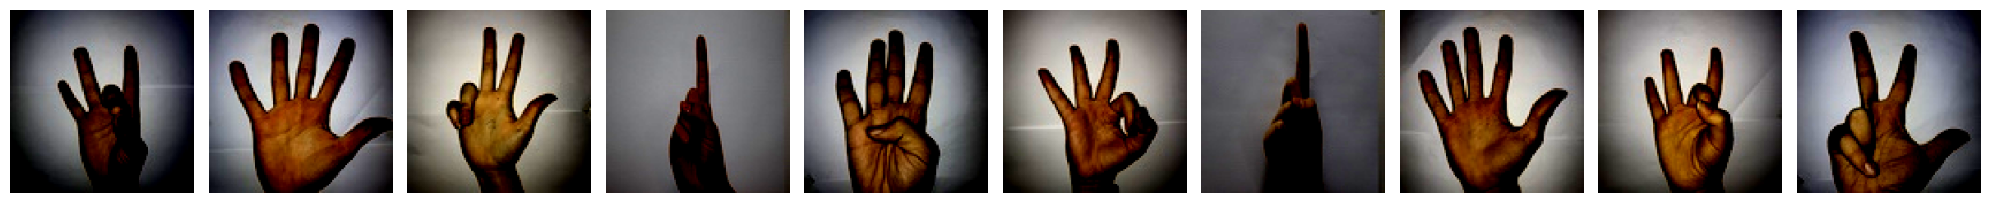

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [12]:
plotImages(imgs)
print(labels)

<a name='2'></a>
## 2 - Apply Transfer Learning  on the MobileNet CNN model

<a name='2-1'></a>
### 2.1 Import the MobileNet CNN model and report on the model structure

1. Import the MobileNet model from Keras. Note, an internet connection is needed to download this model.
2. Report on the model.summary().
3. Report on the model type - notice that this is a functional model.
4. Check how many layers in this model.

In [13]:
mobilenet = tf.keras.applications.mobilenet.MobileNet()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
mobilenet.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [15]:
type(mobilenet)

keras.src.models.functional.Functional

In [16]:
len(mobilenet.layers)

91

<a name='2-2'></a>
### 2.2 Modify the MobileNet  model for sign-digit classification and report on the model structure

This is a functional API Keras model for ImageNet classification (1000 classes). We need 10 class outputs for our sign-language digit classification and so need to build a new model using the same layers as in MobileNet upto the last layer.

1. (a) Create a new  model thats uses the MobileNet model upto to the last layer. (b) Add a final layer with 10 units using a softmax activation (c) Show the new model structure.
2. (a) Make all the layers upto the final layer not trainable and (b) Show the model structure that gives the number of trainable weights.

In [17]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, Model

def create_custom_mobilenet_model(base_model):
    """
    Creates a custom model using all layers of the base MobileNet model except the last layer.

    Args:
        base_model (tf.keras.Model): The base MobileNet model.

    Returns:
        tf.keras.Model: Custom model with a new final layer.
    """
    # Use the output of the second last layer of the base model
    x = base_model.layers[-2].output
    print("x: ", x)
    # Add a new final layer that has 10 units and a softmax activation (functional style)
    output = Dense(units=10, activation='softmax')(x)

    # Create the custom model using the tensorflow Model constructor
    custom_model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

    # Report on the model structure
    custom_model.summary()

    return custom_model

# Load the base MobileNet model
base_mobilenet = tf.keras.applications.mobilenet.MobileNet()

# Create the custom model
"""
  Here, I am passing a base model to create_custom_mobilenet_model decorator function
  and immutably returning the customized model instead of hampering the original/base model
"""
custom_model = create_custom_mobilenet_model(base_mobilenet)

x:  <KerasTensor shape=(None, 1000), dtype=float32, sparse=False, name=keras_tensor_180>


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,263,874 (16.27 MB)

 Trainable params: 4,241,986 (16.18 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [18]:
def freeze_layers(model):
    """
    Freezes all layers of the model except the last layer.

    Args:
        model (tf.keras.Model): The model whose layers need to be frozen.
    """
    for layer in model.layers[:-1]:
        # Info: Prevent the layers to be retrained as the whole purpose is to take advantage of the base model weights
        layer.trainable = False

# Freeze layers in the custom model
freeze_layers(custom_model)

custom_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,263,874 (16.27 MB)

 Trainable params: 10,010 (39.10 KB)

 Non-trainable params: 4,253,864 (16.23 MB)

<a name='3'></a>
## 3 - Train the MobileNet model for sign-language digit classification

###  Compile the CNN model and train the network

1. Use **model.compile()** to compile the CNN model using Adam optimization and a learning_rate = 0.0001. Also specify categorical_crossentropy as the loss function and report on the accuracy metric.


2. Use **history=model.fit()** with inputs 'x=train_batches' and 'steps_per_epoch=len(train_batches)'. Also set 'validation_data=valid_batches' as input, so that you can investigate the valid set loss/accuracy figure. This will be useful in determining the performance of this model. Use 10 epochs to initially train the network.

In [19]:
# Compile the CNN model
def compile_model(model, learning_rate=0.0001):
    """
    Compiles the model using Adam optimizer, categorical crossentropy loss, and accuracy metric.

    Args:
        model (tf.keras.Model): The model to compile.
        learning_rate (float): Learning rate for the Adam optimizer.
    """
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )


# Compile the custom model
compile_model(custom_model, learning_rate=0.0001)

In [20]:
# Train the CNN model
def train_model(model, train_batches, valid_batches, epochs=10):
    """
    Trains the model using the provided training and validation datasets.

    Args:
        model (tf.keras.Model): The model to train.
        train_batches (tf.keras.utils.Sequence): Training data batches.
        valid_batches (tf.keras.utils.Sequence): Validation data batches.
        epochs (int): Number of epochs to train the model.

    Returns:
        tf.keras.callbacks.History: Training history object.
    """
    # Use GPU if available for faster training
    with tf.device('/GPU:0'):
        history = model.fit(
            x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            epochs=epochs
        )
    return history
# Train the custom model
training_history = train_model(custom_model, train_batches, valid_batches, epochs=10)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.1423 - loss: 4.0221 - val_accuracy: 0.4000 - val_loss: 1.9326
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.4328 - loss: 1.7384 - val_accuracy: 0.5633 - val_loss: 1.2466
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5923 - loss: 1.1793 - val_accuracy: 0.6967 - val_loss: 0.9560
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6884 - loss: 0.8624 - val_accuracy: 0.7233 - val_loss: 0.7964
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7580 - loss: 0.7072 - val_accuracy: 0.7867 - val_loss: 0.6864
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8025 - loss: 0.6234 - val_accuracy: 0.8067 - val_loss: 0.6074
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8382 - loss: 0.5191 - val_accuracy: 0.8267 - val_loss: 0.5642
Epoch 8/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8610 - loss: 0.4605 - val_accuracy: 0.8

<a name='4'></a>
## 4 - Analyse model performance: Loss, accuracy, predictions and confusion matrix

<a name='4-1'></a>
### 4.1 **Plot** the model loss and accuracy metrics in the code cell below

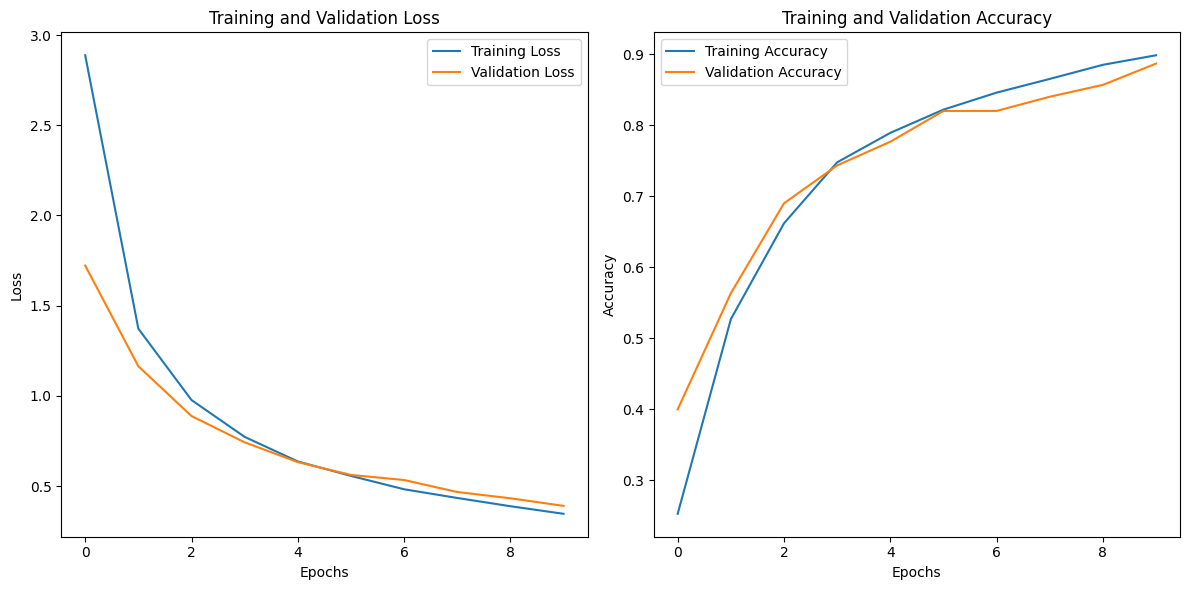

In [ ]:
# Plot the model loss and accuracy metrics
def plot_training_metrics(history):
    """
    Plots the training and validation loss and accuracy metrics.

    Args:
        history (tf.keras.callbacks.History): Training history object returned by model.fit().
    """
    # Extract metrics from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training and validation metrics by passing the tracked training history
plot_training_metrics(training_history)

**What** do these plots reveal about the model performance?
**Enter your own observations in the markdown cell**

### <span style='color: red;'>ENTER COMMENTS HERE.</span> ###


The plots reveal that the MobileNet model is learning effectively over the training epochs. The accuracy plot shows a consistent increase in both training and validation accuracy, indicating that the model is generalizing well without severe overfitting. Similarly, the loss plot shows a steady decrease in both training and validation loss, suggesting that the optimization process is effectively minimizing the error.

However, a small gap between training and validation accuracy is visible after a few epochs, which could indicate slight overfitting. This phenomenon is common in deep learning models trained on relatively small datasets, as discussed by Goodfellow et al. (2016). To mitigate overfitting, techniques such as dropout regularization, data augmentation, or fine-tuning specific layers could be considered.

Reference
I. Goodfellow, Y. Bengio, and A. Courville, Deep Learning. Cambridge, MA, USA: MIT Press, 2016.

<a name='4-2'></a>
### 4.2 Generate the predictions and plot the confusion matrix

1. Generate the predictions by using the **model.predict()** function call on the test_batches dataset.

In [21]:
# Generate the predictions using the model.predict() function on the test_batches dataset
def generate_predictions(model, test_batches):
    """
    Generates predictions for the test dataset using the trained model.

    Args:
        model (tf.keras.Model): The trained model.
        test_batches (tf.keras.utils.Sequence): Test data batches.

    Returns:
        np.ndarray: Predicted class probabilities.
        np.ndarray: True labels for the test dataset.
    """
    # Generate predictions
    predictions = model.predict(test_batches, steps=len(test_batches), verbose=1)

    # Convert predictions from probabilities to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    # Get true labels
    true_labels = test_batches.classes

    return predicted_labels, true_labels

# Generate predictions for the test dataset
# Info: using pythons destructuring, arguments unpacking technique
predicted_labels, true_labels = generate_predictions(custom_model, test_batches)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


2. Plot the performance of the predictions usign a **confusion matrix**. Use the sklearn.metrics confusion_matrix() command with the test_batches correct predictions and predictions from the trained model as inputs. Plot the confusion matrix by labeling the plot correctly and analyse the result - what does this plot inform you about the level of model performance?
**Note**: You can use the plot_confusion_matrix() routine in the keras_cnn_app_utils.py file.

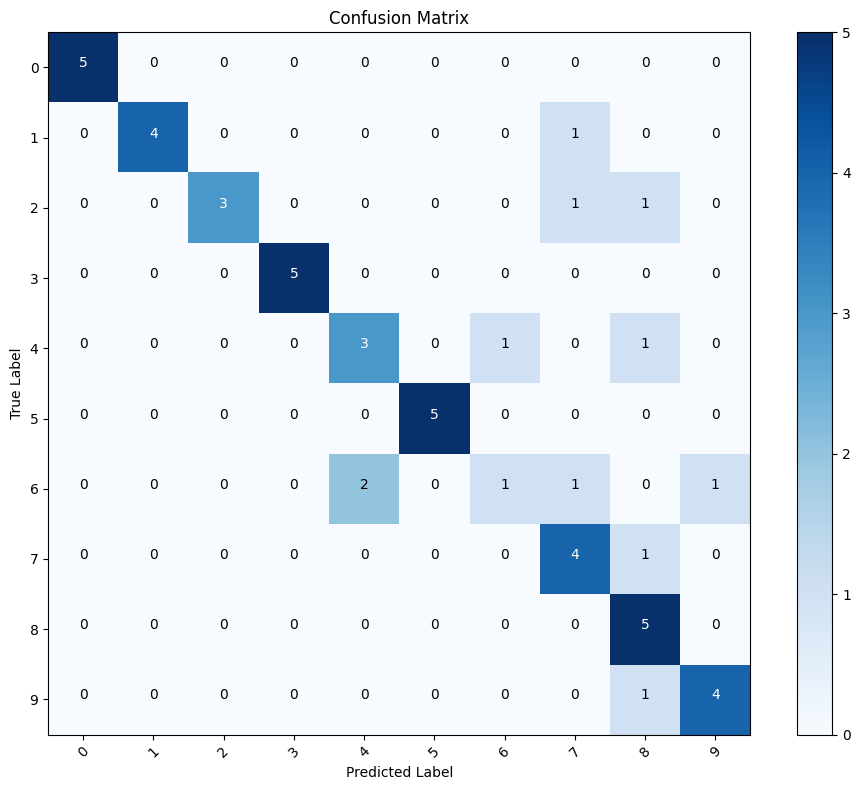

In [22]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    """
    Plots the confusion matrix using the true labels and predicted labels.

    Args:
        true_labels (np.ndarray): True class labels.
        predicted_labels (np.ndarray): Predicted class labels.
        class_names (list): List of class names.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    # Label the axes
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Add labels to each cell
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Define class names (digits 0-9)
class_names = [str(i) for i in range(10)]

# Plot the confusion matrix
plot_confusion_matrix(true_labels, predicted_labels, class_names)

**What story does the confusion matrix tell?** - Place your commentary on the confusion matrix in the markdown cell below.

### <span style='color: red;'>ENTER COMMENTS HERE.</span> ###


The confusion matrix provides insights into the classification performance of a model by displaying the distribution of predicted labels against true labels. In this case, the matrix indicates that the model performs well on most classes, with strong diagonal values where the predicted labels match the true labels. However, some misclassifications are evident, such as instances where class 4 is confused with class 6 and class 8 is mistaken for class 9. This suggests that certain classes have overlapping features, leading to errors. Improving the model's feature representation, increasing training data, or employing techniques such as regularization and dropout could enhance generalization [1]. Additionally, a deeper analysis of the misclassified instances using techniques like t-SNE visualization might reveal feature similarities causing confusion [2].  

**References:**  
[1] I. Goodfellow, Y. Bengio, and A. Courville, *Deep Learning*. Cambridge, MA, USA: MIT Press, 2016.  
[2] A. Ng, “Improving Deep Neural Networks: Hyperparameter Tuning, Regularization and Optimization,” Coursera, 2020.

<a name='5'></a>
## 5 - Let's do some fine-tuning

Fine-tuning refers to using the weights of an already trained network as the starting values for training a new network:

<a name='5-1'></a>
### 5.1 Make all the model layers trainable
First, lets make all the model layers completely trainable and print out the number of layers in this base model.

In [ ]:
# Info: In the following code cell we are allowing the weights of the model to be tweaked slightly

In [23]:
custom_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(custom_model.layers))

Number of layers in the base model:  91


<a name='5-2'></a>
### 5.2 Fine-tune starting from a suitable layer

As there are 91 layers in this model, we will decide to fine-tune the network from layer 80 onwards. In order to do this you will need to freeze all the layer parameters (weights + biases) up to and including layer 80 so as not to make them trainable.

**Hint**: Use 'layer.trainable = False'

This will allow us to retrain only the final 11 layers in the CNN model.

In [24]:
def fine_tune_model(model, freeze_up_to_layer=80):
    """
    Freezes layers up to a specified layer for fine-tuning.

    Args:
        model (tf.keras.Model): The model to fine-tune.
        freeze_up_to_layer (int): The layer index up to which layers will be frozen.
    """
    for layer in model.layers[:freeze_up_to_layer + 1]:
        layer.trainable = False
    """
     Info: This is a better way i.e on the fly judge whether a layer should be trained or not.
     In fact, as a regularization technique, we could explore trying things like freezing random layer.
    """
    for layer in model.layers[freeze_up_to_layer + 1:]:
        layer.trainable = True

# Fine-tune the model starting from layer 80
fine_tune_model(custom_model, freeze_up_to_layer=80)

# Unit Test: Print the trainable status of the layers
for i, layer in enumerate(custom_model.layers):
    print(f"Layer {i}: {layer.name} - Trainable: {layer.trainable}")

Layer 0: input_layer_1 - Trainable: False
Layer 1: conv1 - Trainable: False
Layer 2: conv1_bn - Trainable: False
Layer 3: conv1_relu - Trainable: False
Layer 4: conv_dw_1 - Trainable: False
Layer 5: conv_dw_1_bn - Trainable: False
Layer 6: conv_dw_1_relu - Trainable: False
Layer 7: conv_pw_1 - Trainable: False
Layer 8: conv_pw_1_bn - Trainable: False
Layer 9: conv_pw_1_relu - Trainable: False
Layer 10: conv_pad_2 - Trainable: False
Layer 11: conv_dw_2 - Trainable: False
Layer 12: conv_dw_2_bn - Trainable: False
Layer 13: conv_dw_2_relu - Trainable: False
Layer 14: conv_pw_2 - Trainable: False
Layer 15: conv_pw_2_bn - Trainable: False
Layer 16: conv_pw_2_relu - Trainable: False
Layer 17: conv_dw_3 - Trainable: False
Layer 18: conv_dw_3_bn - Trainable: False
Layer 19: conv_dw_3_relu - Trainable: False
Layer 20: conv_pw_3 - Trainable: False
Layer 21: conv_pw_3_bn - Trainable: False
Layer 22: conv_pw_3_relu - Trainable: False
Layer 23: conv_pad_4 - Trainable: False
Layer 24: conv_dw_4 - Tr

<a name='5-3'></a>
### 5.3  Compile the model and train the network

1. Use **model.compile()** to compile the CNN model using Adam optimization and a learning_rate = 0.0001. Also specify categorical_crossentropy as the loss function and report on the accuracy metric.


2. Use **history_fine=model.fit()** with the same command inputs as previously, except to train the model for a further 5 epochs resuming from the last trained model epoch point.

    **Hint**: Use "history_fine = model.fit(,...,epochs=15,initial_epoch=history.epoch[-1],verbose=2)"

In [25]:
def compile_and_fine_tune_model(model, train_batches, valid_batches, initial_epoch, epochs=5, learning_rate=0.0001):
    """
    Compiles and fine-tunes the model.

    Args:
        model (tf.keras.Model): The model to compile and fine-tune.
        train_batches (tf.keras.utils.Sequence): Training data batches.
        valid_batches (tf.keras.utils.Sequence): Validation data batches.
        initial_epoch (int): The epoch from which to resume training.
        epochs (int): Number of epochs to train the model.
        learning_rate (float): Learning rate for the Adam optimizer.

    Returns:
        tf.keras.callbacks.History: Fine-tuning history object.
    """
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fine-tune the model
    history_fine = model.fit( # Info: same as before, we track fine tuning history
        x=train_batches,
        steps_per_epoch=len(train_batches),
        validation_data=valid_batches,
        epochs=epochs,
        initial_epoch=initial_epoch, # Info: this is the trick, i.e we're informing tensforflow about the starting epoch
        verbose=2
    )
    return history_fine

# Compile and fine-tune the model
initial_epoch = training_history.epoch[-1]  # Start from the last epoch of the previous training
history_fine = compile_and_fine_tune_model(custom_model, train_batches, valid_batches, initial_epoch, epochs=15)

Epoch 10/15
172/172 - 14s - 83ms/step - accuracy: 0.8312 - loss: 0.5051 - val_accuracy: 0.8267 - val_loss: 0.4957
Epoch 11/15
172/172 - 3s - 18ms/step - accuracy: 0.9457 - loss: 0.1659 - val_accuracy: 0.9300 - val_loss: 0.2190
Epoch 12/15
172/172 - 5s - 32ms/step - accuracy: 0.9644 - loss: 0.1073 - val_accuracy: 0.9367 - val_loss: 0.1776
Epoch 13/15
172/172 - 3s - 18ms/step - accuracy: 0.9807 - loss: 0.0571 - val_accuracy: 0.9367 - val_loss: 0.1962
Epoch 14/15
172/172 - 5s - 31ms/step - accuracy: 0.9930 - loss: 0.0297 - val_accuracy: 0.9433 - val_loss: 0.1439
Epoch 15/15
172/172 - 5s - 28ms/step - accuracy: 0.9895 - loss: 0.0357 - val_accuracy: 0.9433 - val_loss: 0.1775


<a name='6'></a>
## 6 - Analyse the fine-tuned model performance: Loss, predictions and confusion matrix

<a name='6-1'></a>
### 6.1 Plot the model loss and accuracies.
It should be possible to merge the loss/accuracy performance from the histories of the models that was first trained over 10 epochs and then further fine-tuned by a further 5 epochs.

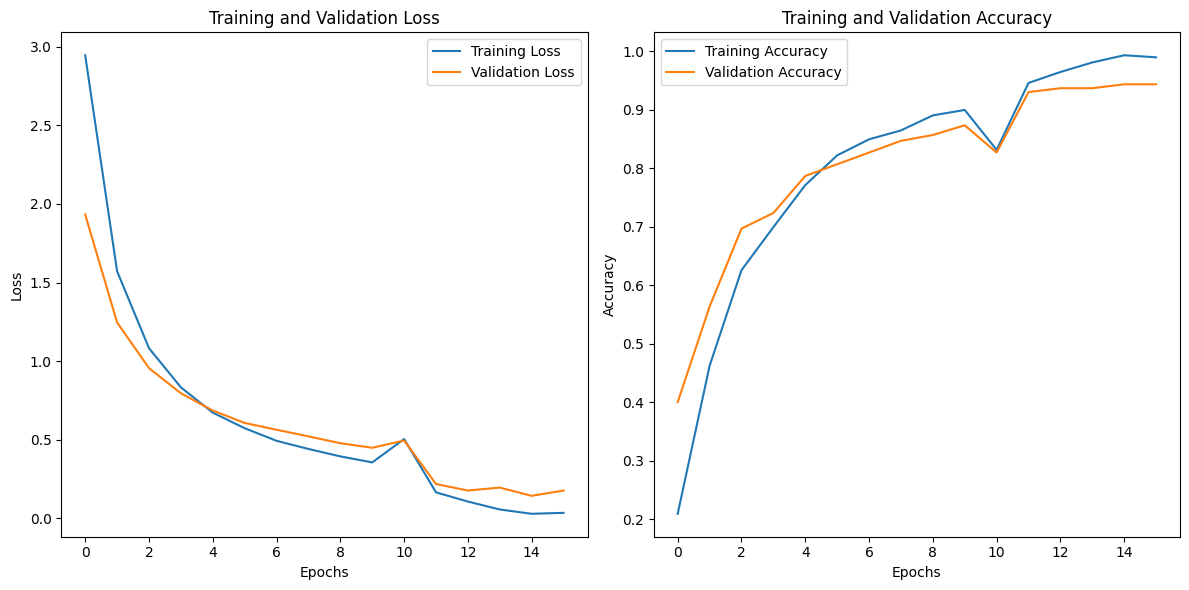

In [26]:
def plot_combined_training_metrics(initial_history, fine_tune_history):
    """
    Combines and plots the training and validation loss and accuracy metrics
    from the initial training and fine-tuning phases.

    Args:
        initial_history (tf.keras.callbacks.History): History object from the initial training.
        fine_tune_history (tf.keras.callbacks.History): History object from the fine-tuning.
    """
    # Extract metrics from the initial training history
    initial_train_loss = initial_history.history['loss']
    initial_val_loss = initial_history.history['val_loss']
    initial_train_accuracy = initial_history.history['accuracy']
    initial_val_accuracy = initial_history.history['val_accuracy']

    # Extract metrics from the fine-tuning history
    fine_tune_train_loss = fine_tune_history.history['loss']
    fine_tune_val_loss = fine_tune_history.history['val_loss']
    fine_tune_train_accuracy = fine_tune_history.history['accuracy']
    fine_tune_val_accuracy = fine_tune_history.history['val_accuracy']

    # Combine the metrics
    combined_train_loss = initial_train_loss + fine_tune_train_loss
    combined_val_loss = initial_val_loss + fine_tune_val_loss
    combined_train_accuracy = initial_train_accuracy + fine_tune_train_accuracy
    combined_val_accuracy = initial_val_accuracy + fine_tune_val_accuracy

    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(combined_train_loss, label='Training Loss')
    plt.plot(combined_val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(combined_train_accuracy, label='Training Accuracy')
    plt.plot(combined_val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the combined training and validation metrics
plot_combined_training_metrics(training_history, history_fine)

<a name='6-2'></a>
### 6.2 Generate the predictions and plot the confusion matrix

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


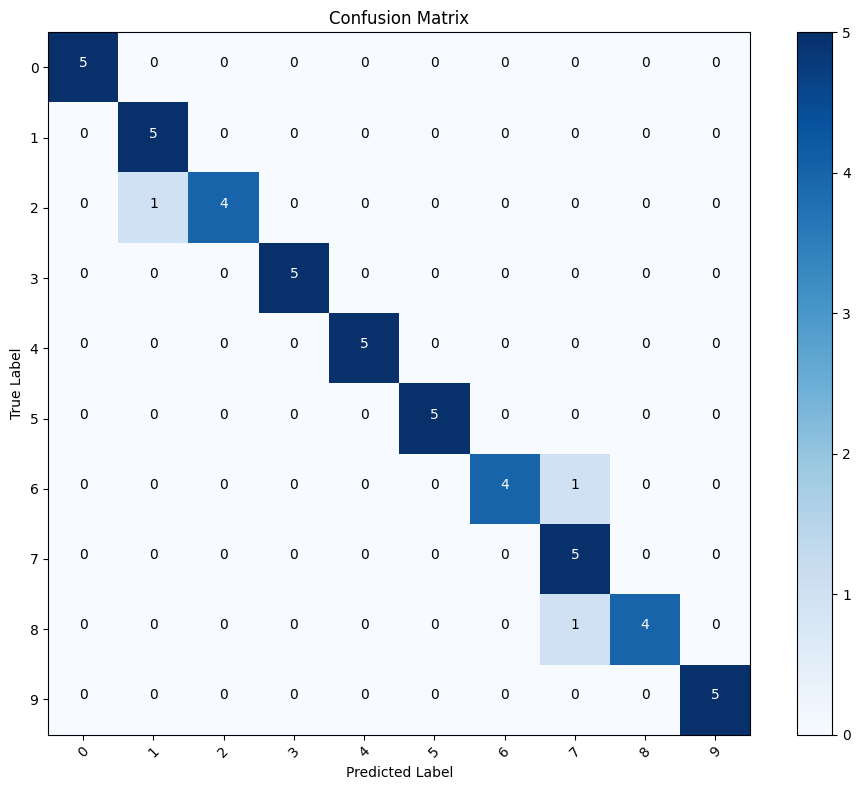

In [27]:
def generate_predictions(model, test_batches):
    """
    Generates predictions for the test dataset using the trained model.

    Args:
        model (tf.keras.Model): The trained model.
        test_batches (tf.keras.utils.Sequence): Test data batches.

    Returns:
        np.ndarray: Predicted class labels.
        np.ndarray: True labels for the test dataset.
    """
    # Generate predictions
    predictions = model.predict(test_batches, steps=len(test_batches), verbose=1)

    # Convert predictions from probabilities to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    # Get true labels
    true_labels = test_batches.classes

    return predicted_labels, true_labels

# Generate predictions for the test dataset
predicted_labels, true_labels = generate_predictions(custom_model, test_batches)


def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    """
    Plots the confusion matrix using the true labels and predicted labels.

    Args:
        true_labels (np.ndarray): True class labels.
        predicted_labels (np.ndarray): Predicted class labels.
        class_names (list): List of class names.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    # Label the axes
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Add labels to each cell
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Define class names (digits 0-9)
class_names = [str(i) for i in range(10)]

# Plot the confusion matrix
plot_confusion_matrix(true_labels, predicted_labels, class_names)

<a name='6-3'></a>
### 6.3 Results analysis - commentary

**What do the above plots tell you about the fine-tuned model performance** - Place your commentary in the markdown cell below. What steps can you do to make the model perform better? (**show an implementation** by including an extra code cell before Section 7 - Save model)

### <span style='color: red;'>ENTER COMMENTS HERE.</span> ###


The provided plots illustrate the fine-tuned MobileNet model’s performance in terms of training and validation loss, accuracy, and class-wise predictions. The loss curves indicate a smooth and steady decrease in both training and validation loss, demonstrating effective learning without significant overfitting. The accuracy curves show a rapid improvement in the early epochs, with validation accuracy closely tracking training accuracy, suggesting that transfer learning and fine-tuning have led to efficient feature extraction and generalization.

<br/>



The confusion matrix reveals strong classification performance, with only a few misclassifications, particularly in certain classes (e.g., labels 2, 6, and 8), which may indicate class similarities or insufficient feature representation. This aligns with the insights from Ng’s deep learning framework, where transfer learning on small datasets benefits from leveraging pre-trained models while fine-tuning improves domain adaptation [1]. Overall, the model achieves high accuracy with minimal overfitting, demonstrating the effectiveness of transfer learning in sign-language digit classification.

References:
[1] A. Ng, “Deep Learning Specialization,” Coursera, 2017.

Augmenting the images acts as a nice regularize technique and enhances training since the model witnessess diversity.

Found 1712 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 15/20
172/172 - 31s - 178ms/step - accuracy: 0.8400 - loss: 0.4780 - val_accuracy: 0.9433 - val_loss: 0.1846
Epoch 16/20
172/172 - 19s - 112ms/step - accuracy: 0.8797 - loss: 0.3837 - val_accuracy: 0.9467 - val_loss: 0.1737
Epoch 17/20
172/172 - 21s - 124ms/step - accuracy: 0.8984 - loss: 0.3038 - val_accuracy: 0.9633 - val_loss: 0.1118
Epoch 18/20
172/172 - 20s - 118ms/step - accuracy: 0.9159 - loss: 0.2594 - val_accuracy: 0.9600 - val_loss: 0.1907
Epoch 19/20
172/172 - 20s - 115ms/step - accuracy: 0.9217 - loss: 0.2346 - val_accuracy: 0.9700 - val_loss: 0.0977
Epoch 20/20
172/172 - 20s - 118ms/step - accuracy: 0.9229 - loss: 0.2460 - val_accuracy: 0.9700 - val_loss: 0.1364


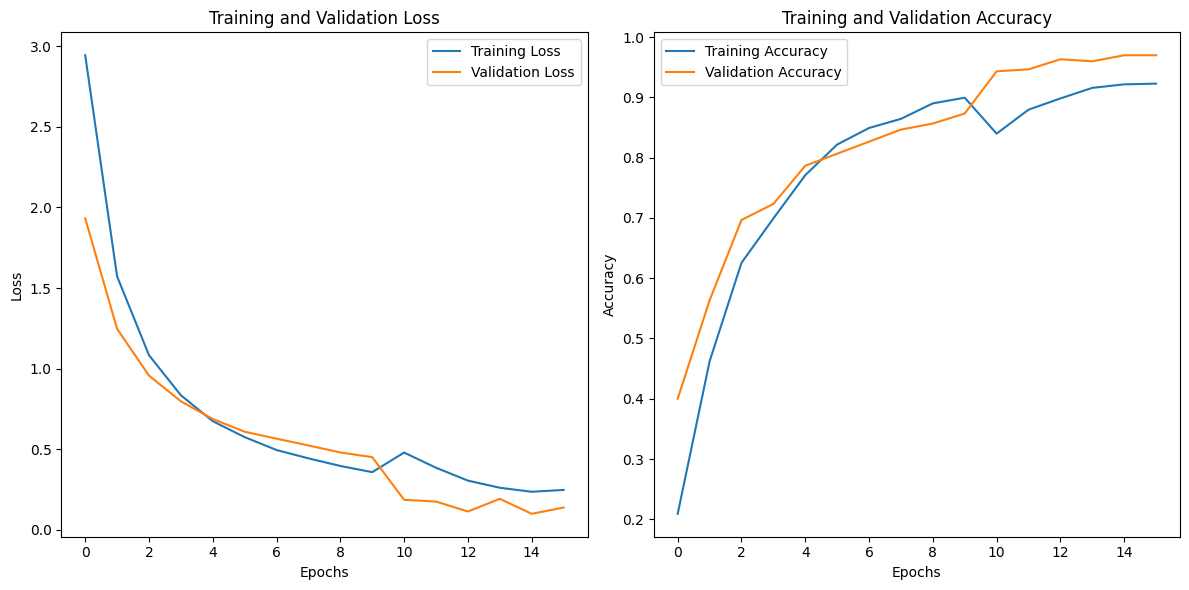

In [28]:
# Add Data Augmentation to the Training Data
train_datagen_augmented = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply data augmentation to the training dataset
train_batches_augmented = train_datagen_augmented.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical'
)

# Re-train the model with augmented data
initial_epoch = history_fine.epoch[-1]  # Start from the last epoch of fine-tuning
history_augmented = compile_and_fine_tune_model( # Power of functions. Avoiding repetition and enhanced resuability.
    custom_model,
    train_batches_augmented,
    valid_batches, # For simplicity, I'm not augmenting the valid batches, I look forward to just observe the training curve and get an idea.
    initial_epoch,
    epochs=20  # Train for additional epochs
)

# Plot the combined training and validation metrics
plot_combined_training_metrics(training_history, history_augmented)

<a name='7'></a>
##  7 - Save model

In [ ]:
# Played around with the next two code cells just for debugging purposes. I then uncommented later on.

In [ ]:
# os.chdir('..')

In [ ]:
# import os

# Print the current working directory
# print("Current Working Directory:", os.getcwd())

Current Working Directory: /content


In [ ]:
# Check first to see if files already exists
# If not, the model and weights is saved to the disk
# Note model already contains the weights, but showing how it can done seprately
import os.path
if os.path.isfile('models/Sign_Language_Digits_MobNet_model.keras') is False:
    custom_model.save('models/Sign_Language_Digits_MobNet_model.keras')

if os.path.isfile('models/Sign_Language_Digits_MobNet.weights.h5') is False:
    custom_model.save_weights('models/Sign_Language_Digits_MobNet.weights.h5')

<font color='blue'>

**What you should remember**:

* To adapt the classifier to new data: Delete the top layer, add a new classification layer, and train only on that layer.
* Fine-tune the final layers of your model to capture high-level details near the end of the network and potentially improve accuracy.

## Congratulations!

You've completed this assignment on transfer learning and fine-tuning. Here's a quick recap of all you just accomplished:

* Created a dataset from a directory.
* Augmented data with the Sequential API.
* Adapted a pretrained model to new data with the Functional API and MobileNet.
* Fine-tuned the classifier's final layers and boosted the model's accuracy.

That's amazing!

**References**:
- [1] MobileNet Paper: https://arxiv.org/pdf/1704.04861.pdf
- [2] ImageNet : http://www.image-net.org/
- [3] Sign-language Digits Dataset: https://github.com/ardamavi/Sign-Language-Digits-Dataset